In [1]:
# 패키지 임포트
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
sns.set()

In [2]:
# ETF 데이터 다운로드
tickers = ['XLB', 'XLE', 'XLF', 'XLI', 'XLK', 'XLP', 'XLU', 'XLV', 'XLY']
etf = yf.Tickers(tickers)
data = etf.history(start='2010-01-01', actions=False)
data.drop(['Open', 'High', 'Low', 'Volume'], inplace=True, axis=1)
data = data.droplevel(0, axis=1).resample('W').last()

[*********************100%***********************]  9 of 9 completed


In [3]:
# 개별 ETF 수익률
rets = data.pct_change().fillna(0)

### 동일 비중 포트폴리오

<Axes: xlabel='Date'>

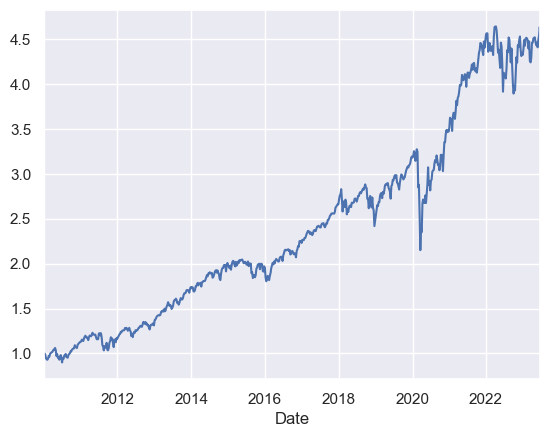

In [4]:
# 동일 가중 포트폴리오 수익률
port_rets = rets.mean(axis=1)

# 동일 가중 포트폴리오 백테스팅
(1 + port_rets).cumprod().plot()

### 포트폴리오 보험

포트폴리오 보험은 내가 지켰으면 하는 포트폴리오 가치의 하한선 대비 현재 포트폴리오의 가치가 어느 정도 수준에 위치하고 있는지에 따라 동적으로 투자 비중을 결정하는 알고리즘입니다. 포트폴리오가 하한선에서 멀어질수록, 즉 성과가 좋으면 좋을수록 투자 비중을 늘리게 되며 하한선에 다다를수록 비중을 줄여나가게 됩니다. 포트폴리오 보험의 목표는 포트폴리오의 가치가 하한선 밑으로 내려가지 못하도록 하는 것입니다. 따라서 포트폴리오의 하한선은 손절(Stop-Loss)의 역할을 하고 있습니다.

$$ w_{t} = \frac{M \times C_{t}}{P_{t}} $$

$$ C_{t} = P_{t} - B_{t} $$

In [5]:
# CPPI 패러미터 설정
# 초기값
init_val = 1

# 하한선 비율 (손절 레벨: 전고점 대비 -30%)
floor = 0.7

# 레버리지 승수 = 3
m = 3

# 시계열 데이터 포인트 수
n_steps = len(port_rets)

포트폴리오 보험의 특징은 매 시점 별로 포트폴리오의 성과가 달라지기 때문에 이와 더불어 하한선 레벨과 쿠션, 그리고 최종적인 투자 비중까지 계속해서 달라진다는 것입니다. 따라서 다른 방법론들과는 다르게 CPPI의 경우에는 벡터화 연산을 사용할 수가 없으며 어쩔 수 없이 `for` 문을 사용하여 이벤트 드리븐 방식으로 구현을 해주어야 합니다.

In [6]:
# 포트폴리오 초기값
port_value = init_val

# 하한선 초기값
floor_value = init_val * floor

# 포트폴리오 전고점
peak = init_val

# 시계열 데이터 저장을 위한 빈 시리즈 정의
# 포트폴리오 가치
port_history = pd.Series(dtype=np.float64).reindex_like(port_rets)
# 투자 가중치
weight_history = pd.Series(dtype=np.float64).reindex_like(port_rets)
# 하한선
floor_history = pd.Series(dtype=np.float64).reindex_like(port_rets)

# 포트폴리오 전략 시뮬레이션

for step in range(n_steps):

    # 전고점
    peak = np.maximum(peak, port_value)

    # 하한선
    floor_value = peak * floor

    # 쿠션
    cushion = (port_value - floor_value) / port_value

    # 투자 비중
    weight = np.maximum(np.minimum(m * cushion, 1), 0)

    # 포트폴리오 가치 계산
    risky_alloc = port_value * weight
    safe_alloc = port_value * (1 - weight)
    port_value = risky_alloc * (1 + port_rets.iloc[step]) + safe_alloc

    # 데이터 저장
    weight_history.iloc[step] = weight
    port_history.iloc[step] = port_value
    floor_history.iloc[step] = floor_value

### 백테스팅 결과

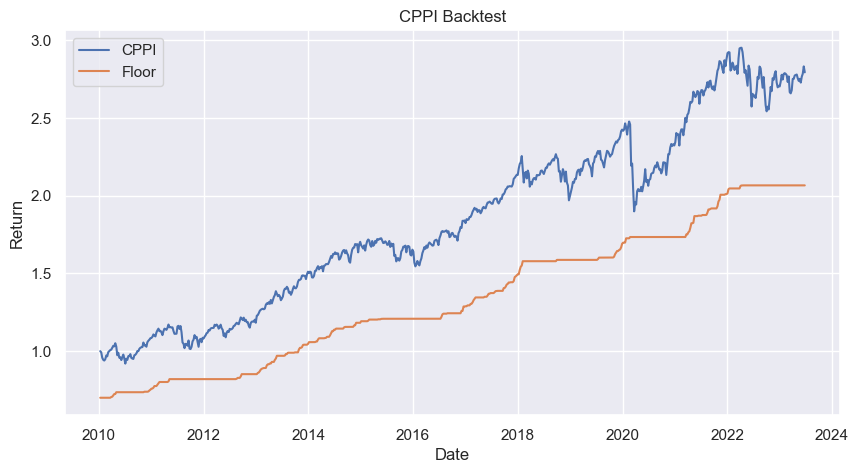

In [7]:
# 백테스팅 결과 시각화
plt.figure(figsize=(10, 5))
plt.plot(port_history, label='CPPI')
plt.plot(floor_history, label='Floor')
plt.title('CPPI Backtest')
plt.xlabel('Date')
plt.ylabel('Return')
plt.legend()
plt.show()

In [8]:
# 투자 비중 데이터프레임 생성
cppi_weights_df = pd.DataFrame(weight_history, index=weight_history.index, columns=['portfolio'])
cppi_weights_df['cash'] = 1 - cppi_weights_df['portfolio']

Text(0, 0.5, 'Weights')

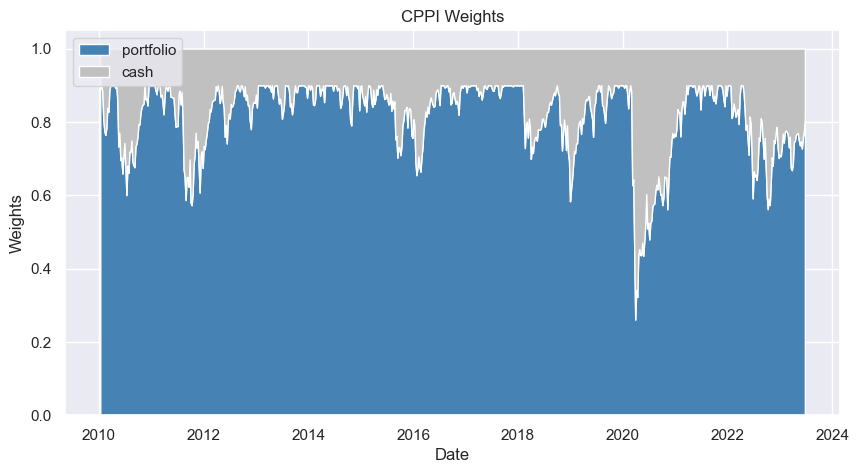

In [9]:
# 시계열 플랏 시각화
plt.figure(figsize=(10, 5))
plt.stackplot(cppi_weights_df.index, cppi_weights_df.T, labels=cppi_weights_df.columns, colors=['steelblue', 'silver'])
plt.legend(loc='upper left')
plt.title('CPPI Weights')
plt.xlabel('Date')
plt.ylabel('Weights')

지금까지 우리는 종적 배분 모델에 대해서 살펴보았습니다. 종적 배분 모델은 횡적 배분 모델에 자산 유니버스 투과시켜 만들어낸 포트폴리오를 매 시점마다 얼마만틈 투자해야 할 것인가를 결정하기 위한 알고리즘입니다. 따라서 종적 배분 모델은 포트폴리오와 현금 간의 투자 비중을 선택한 모델에 기반하여 동적으로 조절합니다. 자산 유니버스 선정과 횡적 배분 모델, 그리고 종적 배분 모델은 우리의 최종 포트폴리오를 만들기 위해 필요한 각각의 프로세스입니다.

다음 시간에는 이 모든 것들을 종합하여 최종 포트폴리오를 만들어주고 또 이 포트폴리오의 백테스팅 결과를 보여줄 수 있는 포트폴리오 백테스팅 엔진을 제작해보도록 하겠습니다.